In [1]:
import utils as ut
from pint import UnitRegistry
import pandas as pd
from ggplot import *
import seaborn as sns
from tabulate import tabulate
from numpy import average as avg
import numpy as np

/Users/pete/src/fcat_biomass/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Some usefull functions and housekeeping
Initalize a `sqlite` database

In [2]:
sqdb = ut.sqlitedb('fcat_biomass')

### Functions for

In [3]:
def distFromRange(total, maxr = 32, minr = 2):
    av = (maxr + minr)/2
    stdev = (float(maxr) - float(minr))/4 
    d_frac = (total-np.floor(total))*np.random.normal(av, stdev, 1).clip(min=0)[0]
    t_bdt = np.random.normal(av,stdev,np.floor(total)).clip(min=0)
    return np.append(t_bdt, d_frac)

In [4]:
def sumFromDist(total, maxr = 0.32, minr = 0.02):
    av = (maxr + minr)/2
    stdev = (float(maxr) - float(minr))/4 
    d_frac = (total-np.floor(total))*np.random.normal(av, stdev, 1).clip(min=0)[0]
    t_bdt = np.sum(np.random.normal(av,stdev,np.floor(total)).clip(min=0))
    return (d_frac+t_bdt)

### Black Carbon from pile burning
The  CARB criteria pollutant emissions inventory reports Particualte Matter (PM 2.5) emissions from anthropogenic buring of forest residuals. The following estimates elemental carbon (Black Carbon) based on empirically derived relationships between PM2.5 and EC from.

1. Ward DE, Hardy CC. Organic and elemental profiles for smoke from prescribed fires. In: Watson JG, editor. International specialty conference of the Air and Waste Management Association [Internet]. San Francisco: Air and Waste Management Association; 1989. Available from: http://www.frames.gov/documents/smoke/serdp/ward_hardy_1989a.pdf

In [5]:
ward = ut.gData('13UQtRfNBSJ81PXxbYSnB2LrjHePNcvhJhrsxRBjHpoY', 475419971)
#Units are ratio of EC to PM produced 
wardDF = ward[['source','pct_sm','pct_f','tc_f_est','tc_f_cv','tc_s_est','tc_s_cv','ec_f_est','ec_f_cv', 'ec_s_est','ec_s_cv','ecton-1_h_pm','ecton-1_l_pm']].transpose()
wardDF.columns = wardDF.iloc[0]
eFact = wardDF.to_dict()
d = dict(zip([eFact[i]['source'] for i in eFact.keys()],['ALL VEGETATION','WILDLAND FIRE USE (WFU)','FOREST MANAGEMENT']))
for k in eFact.keys():
    eFact[k]['arblink'] = d[k]
pd.DataFrame.from_dict(eFact).transpose().to_sql('bc_pm_ratio', sqdb['cx'], if_exists= 'replace')
#print tabulate(pd.DataFrame.from_dict(eFact).transpose(), headers = ['CARB CPE Cat.','BC/t PM 2.5 (high)','BC/t PM 2.5 (low)', 'Source'], tablefmt="pipe")
pd.DataFrame.from_dict(eFact).transpose()

,arblink,ec_f_cv,ec_f_est,ec_s_cv,ec_s_est,ecton-1_h_pm,ecton-1_l_pm,pct_f,pct_sm,source,tc_f_cv,tc_f_est,tc_s_cv,tc_s_est
Pile Burn,FOREST MANAGEMENT,0.45,0.082,0.49,0.029,0.0078985,0.0047115,0.9,0.1,Pile Burn,0.09,0.572,0.01,0.56
Prescribed,WILDLAND FIRE USE (WFU),0.5833,0.1267,0.29,0.034,0.150954,0.0517122,0.5,0.5,Prescribed,0.0733,0.6327,0.08,0.616
Wildfire,ALL VEGETATION,0.4467,0.0962,0.338,0.0367,0.185961,0.0637042,0.3,0.7,Wildfire,0.0867,0.6102,0.06,0.623


In [6]:
pd.DataFrame.from_dict(eFact)

,Pile Burn,Prescribed,Wildfire
arblink,FOREST MANAGEMENT,WILDLAND FIRE USE (WFU),ALL VEGETATION
ec_f_cv,0.45,0.5833,0.4467
ec_f_est,0.082,0.1267,0.0962
ec_s_cv,0.49,0.29,0.338
ec_s_est,0.029,0.034,0.0367
ecton-1_h_pm,0.0078985,0.150954,0.185961
ecton-1_l_pm,0.0047115,0.0517122,0.0637042
pct_f,0.9,0.5,0.3
pct_sm,0.1,0.5,0.7
source,Pile Burn,Prescribed,Wildfire


In [7]:
ward

,source,mg,pct_sm,pct_f,pm2.5_sm,pm2.5_f,tc_f_est,tc_f_cv,tc_s_est,tc_s_cv,...,ec_sm_l(kg),ec_sm_h,ec_f_l,ec_f_h,sumec_l,sumec_h,ecton-1_l_biomass,ecton-1_h_biomass,ecton-1_l_pm,ecton-1_h_pm
0,Pile Burn,10,0.1,0.9,4,36.0,0.5720,0.0900,0.560,0.01,...,0.0592,0.1728,0.1293,0.1431,0.1885,0.3159,0.0188,0.0316,0.004712,0.007898
1,Prescribed,10,0.5,0.5,70,35.0,0.6327,0.0733,0.616,0.08,...,1.7061,3.0539,3.7237,12.7964,5.4298,15.8502,0.5430,1.5850,0.051712,0.150954
2,Wildfire,10,0.7,0.3,96,20.9,0.6102,0.0867,0.623,0.06,...,2.3407,4.1896,5.1085,17.5554,7.4491,21.7450,0.7449,2.1745,0.063704,0.185961


In [8]:
ec_rat_table = pd.DataFrame([ward.source, ward.tc_f_est*ward.ec_f_est, ward.tc_f_cv, ward.ec_f_cv,ward.tc_s_est*ward.ec_s_est, ward.tc_s_cv, ward.ec_s_cv]).transpose()
ec_rat_table.to_sql('ec_ratios', sqdb['cx'], if_exists = 'replace')

-c:2: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.


In [9]:
ec_rat_table

,source,Unnamed 0,tc_f_cv,ec_f_cv,Unnamed 1,tc_s_cv,ec_s_cv
0,Pile Burn,0.046904,0.09,0.45,0.01624,0.01,0.49
1,Prescribed,0.0801631,0.0733,0.5833,0.020944,0.08,0.29
2,Wildfire,0.0587012,0.0867,0.4467,0.0228641,0.06,0.338


In [10]:
print tabulate(ec_rat_table, headers = ['Source',
                                        'BC/t PM 2.5 (F, est.)',
                                        'TC/t PM 2.5 (F, CV)',
                                        'BC/t TC (F, CV)',
                                        'BC/t PM 2.5 (S, est.)',
                                        'TC/t PM 2.5 (S, CV)',
                                        'BC/t TC (S, CV)'], tablefmt="pipe")

|    | Source     |   BC/t PM 2.5 (F, est.) |   TC/t PM 2.5 (F, CV) |   BC/t TC (F, CV) |   BC/t PM 2.5 (S, est.) |   TC/t PM 2.5 (S, CV) |   BC/t TC (S, CV) |
|---:|:-----------|------------------------:|----------------------:|------------------:|------------------------:|----------------------:|------------------:|
|  0 | Pile Burn  |               0.046904  |                0.09   |            0.45   |               0.01624   |                  0.01 |             0.49  |
|  1 | Prescribed |               0.0801631 |                0.0733 |            0.5833 |               0.020944  |                  0.08 |             0.29  |
|  2 | Wildfire   |               0.0587012 |                0.0867 |            0.4467 |               0.0228641 |                  0.06 |             0.338 |


In [11]:
ecPct = ward[['ec_f_est', 'pct_f','pct_sm','tc_f_est','tc_f_cv','tc_s_est','tc_s_cv','ec_f_cv','ec_s_est', 'ec_s_cv']].set_index(ward.source).to_dict('index')

### Black Carbon Global Warming Potential
[Several estimates](https://docs.google.com/spreadsheets/d/13UQtRfNBSJ81PXxbYSnB2LrjHePNcvhJhrsxRBjHpoY/edit#gid=195715938) exist for the GWP of Black Carbon. We use GWP20 estimates for black carbon from the CARB Short-Lived Climate Pollutant Strategy and from Fuglestvedt et. al 2000.

#### References
1. California Air Resources Board. [Short Lived Climate Pollutant Reduction Strategy](https://docs.google.com/uc?id=0B9-9Vlx0SkkFWmxxQ2xtSkNxSlU&export=download). Sacramento, CA; 2015. 
2. Fuglestvedt JS, Berntsen TK, Godal O, Skodvin T. Climate implications of GWP-based reductions in greenhouse gas emissions. Geophys Res Lett [Internet]. 2000 Feb 1 [cited 2015 Sep 5];27(3):409–12. Available from: http://doi.wiley.com/10.1029/1999GL010939

In [12]:
bc_gwp = ut.gData('13UQtRfNBSJ81PXxbYSnB2LrjHePNcvhJhrsxRBjHpoY', 195715938)
bc_gwp.to_sql('bc_gwp', sqdb['cx'], if_exists = 'replace')
#print tabulate(bc_gwp.drop('est_id', 1), headers = [i for i in bc_gwp.drop('est_id', 1).columns],tablefmt="pipe")
bc_gwp = bc_gwp.set_index(bc_gwp.est_id).drop('est_id',1)

In [13]:
bc_gwp

,gwp_20,gwp_20_std,gwp_100,gwp_100_std,gwp_500,gwp_500_std,source
est_id,,,,,,,
fug_meta,2200,888.82,633.33,255.41,193.33,77.67,Fuglestvedt2010
carb_slcp,3200,NaN,900.00,NaN,NaN,NaN,CaliforniaAirResourcesBoard2015


### CARB Criteria Air Pollutant (CAP) emissions data 2015
Particulate Matter, Carbon Monoxide, Nitrogen Oxide, Sulfur Dioxide, Lead, and Reactive Organic Gases

In [5]:
cpe_data = pd.read_csv('http://www.arb.ca.gov/app/emsinv/2013/emsbyeic.csv?F_YR=2015&F_DIV=0&F_SEASON=A&SP=2013&SPN=2013_Almanac&F_AREA=CA')
cpe_data.columns = [i.lower() for i in cpe_data.columns]
cpe_data.to_sql('cpe_2015', sqdb['cx'], if_exists = 'replace')
cpe_2015 = pd.read_sql('''SELECT
                                eicsoun,
                                pm.source type,
                                pm2_5 pm25_tpd,
                                pm2_5*365*"ecton-1_h_pm" as t_ec_high,
                                pm2_5*365*"ecton-1_l_pm" as t_ec_low,
                                pm2_5*365*"ecton-1_h_pm"*gwp_20 as co2e_high,
                                pm2_5*365*"ecton-1_l_pm"*gwp_20 as co2e_low,
                                pm2_5*365*"ecton-1_l_pm"*(gwp_20-gwp_20_std) as co2e20_low_m1std,
                                pm2_5*365*"ecton-1_l_pm"*(gwp_20+gwp_20_std) as co2e20_low_p1std,
                                pm2_5*365*"ecton-1_h_pm"*(gwp_20-gwp_20_std) as co2e20_hi_m1std,
                                pm2_5*365*"ecton-1_h_pm"*(gwp_20+gwp_20_std) as co2e20_hi_p1std,
                                pm2_5*365*"ecton-1_l_pm"*(gwp_100-gwp_100_std) as co2e100_low_m1std,
                                pm2_5*365*"ecton-1_l_pm"*(gwp_100+gwp_100_std) as co2e100_low_p1std,
                                pm2_5*365*"ecton-1_h_pm"*(gwp_100-gwp_100_std) as co2e100_hi_m1std,
                                pm2_5*365*"ecton-1_h_pm"*(gwp_100+gwp_100_std) as co2e100_hi_p1std,
                                gwp.source
                            FROM cpe_2015
                            JOIN bc_pm_ratio pm  on  (arblink = eicsoun)
                            CROSS JOIN bc_gwp gwp 
                            WHERE eicsoun in ('FOREST MANAGEMENT','WILDLAND FIRE USE (WFU)','ALL VEGETATION')''',
            con = sqdb['cx'])

foo = pd.melt(cpe_2015.drop('eicsoun',1), id_vars = ['type', 'source'])
bar = foo[foo['variable'].str.contains("co2e")].dropna()
bar['type'] = bar.type.astype('category')
bar.value = bar.value

In [7]:
bar

,type,source,variable,value
18,Wildfire,Fuglestvedt2010,co2e_high,56306313.753166
19,Wildfire,CaliforniaAirResourcesBoard2015,co2e_high,81900092.731877
20,Pile Burn,Fuglestvedt2010,co2e_high,95233.204182
21,Pile Burn,CaliforniaAirResourcesBoard2015,co2e_high,138521.024265
22,Prescribed,Fuglestvedt2010,co2e_high,2259086.154883
23,Prescribed,CaliforniaAirResourcesBoard2015,co2e_high,3285943.498012
24,Wildfire,Fuglestvedt2010,co2e_low,19288763.710947
25,Wildfire,CaliforniaAirResourcesBoard2015,co2e_low,28056383.579559
26,Pile Burn,Fuglestvedt2010,co2e_low,56807.145851
27,Pile Burn,CaliforniaAirResourcesBoard2015,co2e_low,82628.575783


#### Make the BC GHG emissions plot

A secondary apporoach based on Ward (1989) and Jenkins (1996) uses a range of 2-32% of PM as BC. 

1. Jenkins BM, Turn SQ, Williams RB, Goronea M, Abd-el-Fattah H, Mehlschau J, et al. Atmospheric Pollutant Emissions Factors From Open Burning of Agricultural and Forest Biomass By Wind Tunnel Simulations [Internet]. Sacramento, CA; 1996. Available from: http://www.arb.ca.gov/ei/speciate/r01t20/rf9doc/refnum9.htm

In [15]:
pm2015=pd.read_sql('''select eicsoun,
                    pm2_5*365 as pm25
                from cpe_2015
                WHERE eicsoun in ('FOREST MANAGEMENT','WILDLAND FIRE USE (WFU)','ALL VEGETATION');''', con = sqdb['cx'])
pm2015=pm2015.set_index([['Wildfire','Pile Burn','Prescribed']])

In [16]:
pm2015

,eicsoun,pm25
Wildfire,ALL VEGETATION,137630.1485
Pile Burn,FOREST MANAGEMENT,5480.5115
Prescribed,WILDLAND FIRE USE (WFU),6802.4320


In [17]:
def ecDist(ecEst, ecCV, PM):
    '''
    PM is a mass measure, its intended to be PM2.5
    ecEst is the estimate of the percentage of elemental carbon comprising the PM
    ecCV is the coefficient of variation around the estimate of elemental carbon
    -----
    returns a random selection from a normal distribution of size `len(pm)`
    centered on `ecEst` with standard deviation of `ecCV`*`ecEst`
    '''
    ecStdev = ecCV * ecEst
#    ec_frac = (PM-np.floor(PM))*np.random.normal(ecEst, ecStdev, 1).clip(min=0)[0]
    t_ec = np.random.normal(ecEst,ecStdev,PM).clip(min=0)#+ec_frac
    return t_ec #+ ec_frac

In [18]:
ecPct

{'Pile Burn': {'ec_f_cv': 0.45000000000000001,
  'ec_f_est': 0.082000000000000003,
  'ec_s_cv': 0.48999999999999999,
  'ec_s_est': 0.029000000000000001,
  'pct_f': 0.90000000000000002,
  'pct_sm': 0.10000000000000001,
  'tc_f_cv': 0.089999999999999997,
  'tc_f_est': 0.57199999999999995,
  'tc_s_cv': 0.01,
  'tc_s_est': 0.56000000000000005},
 'Prescribed': {'ec_f_cv': 0.58330000000000004,
  'ec_f_est': 0.12670000000000001,
  'ec_s_cv': 0.28999999999999998,
  'ec_s_est': 0.034000000000000002,
  'pct_f': 0.5,
  'pct_sm': 0.5,
  'tc_f_cv': 0.073300000000000004,
  'tc_f_est': 0.63270000000000004,
  'tc_s_cv': 0.080000000000000002,
  'tc_s_est': 0.61599999999999999},
 'Wildfire': {'ec_f_cv': 0.44669999999999999,
  'ec_f_est': 0.096199999999999994,
  'ec_s_cv': 0.33800000000000002,
  'ec_s_est': 0.036700000000000003,
  'pct_f': 0.29999999999999999,
  'pct_sm': 0.69999999999999996,
  'tc_f_cv': 0.086699999999999999,
  'tc_f_est': 0.61019999999999996,
  'tc_s_cv': 0.059999999999999998,
  'tc_s_

In [19]:
for k in ecPct.keys():
    pm = pm2015.loc[k]['pm25']
    ecPct[k]['t_pm'] = pm
    #PM2.5 smoldering 
    pm_sm = ecPct[k]['pct_sm']*pm
    ecPct[k]['pm_sm'] = pm_sm
    #TC smoldering
    tc_sm = ecPct[k]['tc_s_est']*pm_sm
    ecPct[k]['tc_sm'] = tc_sm
    #PM2.5 flaming
    pm_f = ecPct[k]['pct_f']*pm
    ecPct[k]['pm_f'] = pm_f
    #TC flaming
    tc_f = ecPct[k]['tc_f_est']*pm_f
    ecPct[k]['tc_f'] = tc_f
    res1k = []
    for t in range(1000):
        rnd = t
        # Total Carbon in PM
        tc_s = ecDist(ecPct[k]['tc_s_est'], ecPct[k]['tc_s_cv'], pm)
        tc_f = ecDist(ecPct[k]['tc_f_est'], ecPct[k]['tc_f_cv'], pm)
        #Elemental Carbon in Total Carbon
        ec_s = ecDist(ecPct[k]['ec_s_est'], ecPct[k]['ec_s_cv'], pm)
        ec_f = ecDist(ecPct[k]['ec_f_est'], ecPct[k]['ec_f_cv'], pm)
        ec1tpm = (tc_s*ec_s) + (tc_f*ec_f)
        ec_total_rnd = sum(ec1tpm)
        ec_total_gwp = ec_total_rnd * bc_gwp.loc['carb_slcp']['gwp_20']
        res1k.append([k,k+str(rnd),ec_total_rnd, ec_total_gwp])
    ecPct[k]['ec_tdist'] = pd.DataFrame(res1k)
    #ecPct[k]['ecSMDist'] = np.array([(ecDist(ecPct[k]['ec_s_est'], ecPct[k]['ec_s_cv'], pm)) for i in range(1000)])
    #ecPct[k]['ecFDist'] = np.array([(ecDist(ecPct[k]['ec_f_est'], ecPct[k]['ec_f_cv'], pm)) for i in range(1000)])
    #ecPct[k]['tECDist'] = ecPct[k]['ecSMDist']+ecPct[k]['ecFDist']
    #ecPct[k]['df'] = pd.DataFrame(np.column_stack((ecPct[k]['tECDist'], [k]*len(ecPct[k]['tECDist']))))

In [20]:
ecPct['Prescribed']['tc_f']

2151.9493632000003

In [21]:
(pm_sm*0.2*3200)+(pm_f*0.2*3200)

3507527.3600000003

In [22]:
df=pd.concat([ecPct[i]['ec_tdist'] for i in ecPct.keys()])
df.columns = ['source', 'sourcernd', 'mt_ec','co2e_ec']

/Users/pete/src/fcat_biomass/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


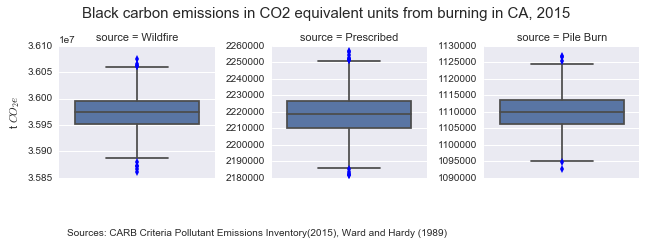

In [23]:
t=sns.FacetGrid(df,col='source', sharey=False)
t.map(sns.boxplot, 'source','co2e_ec')
t.set_ylabels('t $CO_2e$')
[c.xaxis.set_visible(False) for c in t.axes[0]]
sns.plt.subplots_adjust(top = 0.8)
t.fig.suptitle('Black carbon emissions in CO2 equivalent units from burning in CA, 2015', fontsize= 15)
t.fig.text(0.1, -0.08,'''Sources: CARB Criteria Pollutant Emissions Inventory(2015), Ward and Hardy (1989)''',
      fontsize=10)
for f in ['.png','.pdf']:
    t.savefig('graphics/bc_prob_gwp{0}'.format(f))

In [24]:
122*0.66

80.52000000000001

In [25]:
pd.read_csv('fera_pile_cemissions.csv', header=1)

,Group ID/Name,Number of Piles,Pile Type,Pile Shape,W1 (ft),H1 (ft),L1 (ft),W2 (ft),H2 (ft),L2 (ft),...,Adjusted Volume (ft^3),Pile Biomass (tons),Consumed Fuel (tons),PM (tons),PM10 (tons),PM2.5 (tons),CO (tons),CO2 (tons),CH4 (tons),NMHC (tons)
PileGroup1,1,1,Half sphere,NaN,10,NaN,NaN,NaN,NaN,NaN,...,1007.169088,1.360178,1.224161,0.013405,0.009487,0.008263,0.046502,2.036643,0.003431,0.00277


### Forested Lands and Wood Products Biodegradable Carbon Emissions & Sinks (MMTCO2)
ARB (2007). Technical support document for Land Use, Land Use Change & Forestry - Biodegradable Carbon Emissions & Sinks. Table available as a pdf document at: http://www.arb.ca.gov/cc/inventory/archive/tables/net_co2_flux_2007-11-19.pdf

In [26]:
t=foo[foo['variable'].str.contains("co2e20")].dropna()
co2 = ut.gData('1GDdquzrCoq2cxVN2fbCpP4gwi2yrMnONNrWbfhZKZu4', 1636249481)
co2.columns = co2.iloc[0]
co2plot=pd.melt(co2.reindex(co2.index.drop(0)), id_vars = ['Year'])
co2plot.columns = ['sc_cat','year','mmtco2e']
co2plot.to_sql('arb_co2', sqdb['cx'], if_exists = 'replace')
cdata = pd.read_sql('''select sc_cat, avg(mmtco2e) from arb_co2 where sc_cat in ('Forest and rangeland fires', 'Timber harvest slash')  group by sc_cat''', con = sqdb['cx'])

In [27]:
co2

,Year,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0
0,Year,1990.000,1991.000,1992.000,1993.000,1994.000,1995.000,1996.000,1997.000,1998.000,1999.000,2000.000,2001.000,2002.000,2003.000,2004.000
1,Forest and rangeland fires,2.032,2.028,2.025,2.022,2.018,2.018,2.018,2.018,2.018,2.018,2.018,2.017,2.015,2.014,2.012
2,Other disturbances,1.208,1.206,1.204,1.202,1.200,1.200,1.200,1.200,1.200,1.200,1.200,1.199,1.198,1.197,1.196
3,Development of forest or range lands (Landuse ...,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021
4,Timber harvest slash,0.156,0.156,0.156,0.156,0.155,0.155,0.155,0.155,0.155,0.155,0.155,0.155,0.155,0.155,0.155


In [28]:
cdata
#Output GitHub Markdown using the following:
#print tabulate(cdata, headers = ['Source Category','MMTCO2'],tablefmt="pipe")

,sc_cat,avg(mmtco2e)
0,Forest and rangeland fires,2.019400
1,Timber harvest slash,0.155267


### GHG equivalent emissions from management residuals
To arrive at an estimate of total annual emissions from buring forest management residuals in CO2 equivalent terms from published CARB estimates we can combine the CO2 emissions reported for 2004 in the LULUC Biodegradable Carbon Emissions and Sinks with black carbon emissions extrapolated from the CARB Criteria Air Pollutant Emissions inventory estimates. The dime discreppancy between the 2004 and 2015 is acknowledged as an irreconcilable source of uncertainty in this estimation among others. This does however reflect that a baseline of substantial emissions from forest management residuals has been reported in CARB emissions inventories and should be recognized as a baseline condition.  

In [29]:
t=foo[foo['variable'].str.contains("co2e20")].dropna()
tE = pd.DataFrame([cdata['avg(mmtco2e)'][1]*1.10231,
              avg(t[t['type'].str.contains('piles')]['value'])/1000000,
             (cdata['avg(mmtco2e)'][1]*1.10231)+(avg(t[t['type'].str.contains('piles')]['value'])/1000000)],columns = ['Mt CO2e'])
tE['Source']=['CO2 pile buring', 'CO2e BC pile burning', 'Total Mt CO2e']
tE.to_sql('pile_em', sqdb['cx'], if_exists = 'replace')

/Users/pete/src/fcat_biomass/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
-c:6: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.


In [30]:
#print tabulate(tE, headers = tE.columns.tolist(), tablefmt ='pipe')
tE

,Mt CO2e,Source
0,0.171152,CO2 pile buring
1,NaN,CO2e BC pile burning
2,NaN,Total Mt CO2e


### Timber Products Output
The TPO estimates logging redisues produced from commercial timber harvesting operations.

In [14]:
tpoData = ut.gData('1GDdquzrCoq2cxVN2fbCpP4gwi2yrMnONNrWbfhZKZu4', 872275354, hrow=1)
tpoData

,ownership,roundwoodproducts,loggingresidues,year
0,National Forest,72.4,20.7,2012
1,Other Public,16.2,3.4,2012
2,Forest Industry,328.9,72.4,2012
3,Other Private,53.0,11.2,2012
4,National Forest,52.8,16.3,2006
5,Other Public,1.1,0.3,2006
6,Forest Industry,274.3,59.6,2006
7,Other Private,139.2,33.2,2006
8,National Forest,90.8,22.6,2000
9,Other Public,5.2,1.6,2000


### Biomass residuals from non-commercial management activities
Data from TPO does not account for forest management activities that do not result in commercial products (timber sales, biomass sales). To estimate the amount of residual material produced from non commercial management activities we use data from the US Forest Service (FACTS) and from CalFires timber harvest plan data. 

#### Forest Service ACtivity Tracking System (FACTS)
Data from TPO does not account for forest management activities that do not result in commercial products (timber sales, biomass sales). We use a range of 10-35 BDT/acre to convert acres reported in FACTS to volume.

In [12]:
pd.read_excel('FACTS_Tabular_092115.xlsx', sheetname = 'CategoryCrosswalk').to_sql('facts_cat', sqdb['cx'], if_exists = 'replace')

In [13]:
pd.read_csv('pd/facts_notimber.csv').to_sql('facts_notimber', sqdb['cx'], if_exists='replace')

#### Querying FACTS
The USFS [reports](http://data.fs.usda.gov/geodata/edw/datasets.php?dsetParent=Activities) Hazardous Fuels Treatment (HFT) activities as well as Timber Sales (TS) derived from the FACTS database. We use these two datasets to estimate the number of acres treated that did not produce commercial material (sawlogs or biomass) and where burning was not used. The first step is to elimina all treatments in the HFT dataset that included timber sales. We accomplish this by eliminating all rows in the HFT dataset that have identical `FACTS_ID` fields in the TS dataset. We further filter the HFT dataset by removing any planned but not executed treatements (`nbr_units1 >0` below -- `nbr_units1` references `NBR_UNITS_ACCOMPLISHED` in the USFS dataset, see metadata for HFT [here](http://data.fs.usda.gov/geodata/edw/edw_resources/meta/S_USA.Activity_HazFuelTrt_PL.xml)), and use text matching in the 'ACTIVITY' and 'METHOD' fields to remove any rows that contain reference to 'burning' or 'fire'. Finally, we remove all rows that that reference 'Biomass' in the method category as it is assumed that this means material was removed for bioenergy.

In [14]:
usfs_acres = pd.read_sql('''select
                                sum(nbr_units1) acres,
                                method,
                                strftime('%Y',date_compl) year,
                                cat."ACTIVITY" activity,
                                cat."TENTATIVE_CATEGORY" r5_cat
                            from facts_notimber n 
                                join facts_cat cat
                                    on (n.activity = cat."ACTIVITY") 
                            where date_compl is not null
                                and nbr_units1 > 0
                                and cat."TENTATIVE_CATEGORY" != 'Burning'
                                and cat."ACTIVITY" not like '%ire%'
                                and method not like '%Burn%'
                                and method != 'Biomass'
                            group by cat."ACTIVITY",
                                year,
                                method,
                                cat."TENTATIVE_CATEGORY"
                            order by year;''', con = sqdb['cx'])

#### Converting acres to cubic feet
FACTS reports in acres. To estimate the production of biomass from acres treated we use a range of 10-35 BDT/acre. We assume that actual biomass residuals per acre are normally distributed with a mean of 22.5 and a standard deviation of (35-10)/4 = 6.25 

In [15]:
def sumBDT(ac, maxbdt = 35, minbdt = 10):
    av = (maxbdt + minbdt)/2
    stdev = (float(maxbdt) - float(minbdt))/4 
    d_frac = (ac-np.floor(ac))*np.random.normal(av, stdev, 1).clip(min=0)[0]
    t_bdt = np.sum(np.random.normal(av,stdev,np.floor(ac)).clip(min=0))
    return d_frac+t_bdt

In [16]:
usfs_acres['bdt'] = usfs_acres['acres'].apply(sumBDT)
usfs_an_bdt = usfs_acres.groupby(['year']).sum()

#### Weighted average wood density
Average wood density weighted by harvested species percent. Derived from McIver and Morgan,  [Table 4](https://docs.google.com/spreadsheets/d/138FWlGeW57MKdcz2UkWxtWV4o50SZO8sduB1R6JOFp8/edit#gid=393414465)

In [17]:
wood_dens = ut.gData('138FWlGeW57MKdcz2UkWxtWV4o50SZO8sduB1R6JOFp8', 1297253755)
wavg_dens =sum(wood_dens.pct/100 * wood_dens.density_lbscuft)

### Annual unutilized management residuals
- [x] Public lands non-commercial management residuals 
- [ ] Private land non-commercial management residuals
- [x] Public lands logging residuals
- [x] Private lands logging residuals

In [60]:
cat_codes = {'nf_ncmr': 'Unburned, non-commercial management residuals from National Forest lands',
             'nf_lr': 'Logging residuals generated from timber sales on National Forest lands',
             'opriv_lr': 'Logging residuals generated from timber sales on non-industrial private forest lands',
             'fi_lr': 'Logging residuals generated from timber sales on industrial private lands',
             'opub_lr': 'Logging residuals generated from timber sales on industrial private lands'}

In [48]:
usfs_an_bdt['cuft']= usfs_an_bdt.bdt *wavg_dens
resid_stats=pd.DataFrame((usfs_an_bdt.iloc[6:,2]/1000000).describe())
resid_stats.columns = ['nf_ncmr']
resid_stats['nf_lr']=tpoData[tpoData.ownership.str.contains('National Forest')]['loggingresidues'].describe()
resid_stats['opriv_lr']=tpoData[tpoData.ownership.str.contains('Other Private')]['loggingresidues'].describe()
resid_stats['fi_lr']=tpoData[tpoData.ownership.str.contains('Forest Industry')]['loggingresidues'].describe()
resid_stats['opub_lr']=tpoData[tpoData.ownership.str.contains('Other Public')]['loggingresidues'].describe()
resid_stats

,nf_ncmr,nf_lr,opriv_lr,fi_lr,opub_lr
count,11.000000,4.00000,4.000000,4.000000,4.000000
mean,12.019440,17.70000,28.950000,66.425000,2.400000
std,4.689480,5.07346,16.159311,6.076389,1.794436
min,2.374210,11.20000,11.200000,59.600000,0.300000
25%,8.924072,15.02500,19.525000,62.225000,1.275000
50%,13.355718,18.50000,27.750000,66.850000,2.500000
75%,14.534933,21.17500,37.175000,71.050000,3.625000
max,17.853204,22.60000,49.100000,72.400000,4.300000


In [63]:
print tabulate(resid_stats, headers = resid_stats.columns.tolist(), tablefmt ='pipe')

|       |   nf_ncmr |    nf_lr |   opriv_lr |    fi_lr |   opub_lr |
|:------|----------:|---------:|-----------:|---------:|----------:|
| count |  11       |  4       |     4      |  4       |   4       |
| mean  |  12.0194  | 17.7     |    28.95   | 66.425   |   2.4     |
| std   |   4.68948 |  5.07346 |    16.1593 |  6.07639 |   1.79444 |
| min   |   2.37421 | 11.2     |    11.2    | 59.6     |   0.3     |
| 25%   |   8.92407 | 15.025   |    19.525  | 62.225   |   1.275   |
| 50%   |  13.3557  | 18.5     |    27.75   | 66.85    |   2.5     |
| 75%   |  14.5349  | 21.175   |    37.175  | 71.05    |   3.625   |
| max   |  17.8532  | 22.6     |    49.1    | 72.4     |   4.3     |


In [120]:
import os

In [133]:
[os.path.splitext(i)[0] for i in os.listdir('lf/') if os.path.splitext(i)[1] =='.csv']

['ignition_requests',
 'system_counties',
 'current_burns',
 'district_smp_comments',
 'system_air_districts',
 'cover_types',
 'smp_smoke_sensitive_areas',
 'smp_contact_methods',
 'smp_landowner_information',
 'smp_misc_comments',
 'current_burns_status',
 'ignitions',
 'smp_land_manager_information',
 'smp_pile_units',
 'system_air_basins',
 'smp_smoke_mitigation',
 'smp_broadcast_units',
 'smp_alternatives_to_burning']

In [9]:
ureg = UnitRegistry()
ureg.define('cubic foot =  cubic_centimeter/ 3.53147e-5 = cubic_foot' )
ureg.define('million cubic foot =  cubic_foot*1000000 = MMCF' )
ureg.define('board foot sawlog = cubic_foot / 5.44 = BF_saw')
ureg.define('board foot veneer = cubic_foot / 5.0 = BF_vo')
ureg.define('board foot bioenergy = cubic_foot / 1.0 = BF_bio')
ureg.define('bone-dry unit = cubic_foot * 96 = BDU')
